## 进入MMSegmentation主目录

In [1]:
# 进入主目录
import os
os.chdir('mmsegmentation')

## 导入工具包

In [4]:
import numpy as np
from PIL import Image

import os.path as osp
from tqdm import tqdm

import mmcv
import mmengine
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# 数据集图片和标注路径
data_root = 'data/Watermelon87_Semantic_Seg_Mask'

# 类别和对应的颜色
classes = ('background','watermelon_edge', 'watermelon_peel','Watermelon_pulp','watermelon_seed_white','watermelon_seed_black')
palette = [[0,0,0],[255,255,255],[0,255,0],[255,0,0],[0,0,255],[128,128,128]]

## 修改数据集类（指定图像扩展名）

In [ ]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

@DATASETS.register_module()
class StanfordBackgroundDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)

## 修改config配置文件

In [5]:
from mmengine import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')

In [12]:
cfg.norm_cfg = dict(type='BN', requires_grad=True) # 只使用GPU时，BN取代SyncBN
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 6
cfg.model.auxiliary_head.num_classes = 6

# 修改数据集的 type 和 root
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 8

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path='img_dir/train', seg_map_path='ann_dir/train')
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
#cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path='img_dir/val', seg_map_path='ann_dir/val')
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
#cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader


# 载入预训练模型权重
cfg.load_from = 'https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# 工作目录
cfg.work_dir = './work_dirs/watermelon'

# 训练迭代次数
cfg.train_cfg.max_iters = 800
# 评估模型间隔
cfg.train_cfg.val_interval = 400
# 日志记录间隔
cfg.default_hooks.logger.interval = 100
# 模型权重保存间隔
cfg.default_hooks.checkpoint.interval = 200
#模型权重最多保留个数
cfg.default_hooks.checkpoint.max_keep_ckpts = 5
#模型权重自动保留最佳
cfg.default_hooks.checkpoint.save_best = 'auto'

# 随机数种子
cfg['randomness'] = dict(seed=0)

## 保存config配置文件

In [13]:
cfg.dump('watermelon_cfg.py')

## 准备训练

In [14]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner
register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

06/14 23:41:46 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.10 (default, Jun  4 2021, 15:09:15) [GCC 7.5.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.3, V11.3.109
    GCC: gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
    PyTorch: 1.10.0+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=

/root/miniconda3/lib/python3.8/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


06/14 23:41:49 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
06/14 23:41:49 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

### 不再重新加载修改配置文件的情况下，准备训练

In [7]:
from mmengine import Config
cfg = Config.fromfile('watermelon_cfg.py')

In [6]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner
register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

06/15 13:50:49 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.10 (default, Jun  4 2021, 15:09:15) [GCC 7.5.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.3, V11.3.109
    GCC: gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
    PyTorch: 1.10.0+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=

/root/autodl-tmp/pythonProject/openmmlab_ai/MMSegmentation_homework/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/root/autodl-tmp/pythonProject/openmmlab_ai/MMSegmentation_homework/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/root/autodl-tmp/pythonProject/openmmlab_ai/MMSegmentation_homework/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


06/15 13:50:55 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
06/15 13:50:55 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/root/autodl-tmp/pythonProject/openmmlab_ai/MMSegmentation_homework/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


## 开始训练

如果遇到报错`CUDA out of memeory`，重启实例或使用显存更高的实例即可。

In [8]:
runner.train()

06/15 13:52:14 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
06/15 13:52:15 - mmengine - INFO - load model from: open-mmlab://resnet50_v1c
06/15 13:52:15 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet50_v1c
06/15 13:52:15 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([6, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is to

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

## 用训练得到的模型做预测

## 导入工具包

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mmseg.apis import init_model, inference_model, show_result_pyplot
import mmcv
import cv2

## 载入模型

In [9]:
# 载入 config 配置文件
from mmengine import Config
cfg = Config.fromfile('watermelon_cfg.py')

In [10]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner

register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

06/16 15:17:50 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.10 (default, Jun  4 2021, 15:09:15) [GCC 7.5.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.3, V11.3.109
    GCC: gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
    PyTorch: 1.10.0+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=

/root/autodl-tmp/pythonProject/openmmlab_ai/MMSegmentation_homework/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/root/autodl-tmp/pythonProject/openmmlab_ai/MMSegmentation_homework/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/root/autodl-tmp/pythonProject/openmmlab_ai/MMSegmentation_homework/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


06/16 15:17:58 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
06/16 15:17:58 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/root/autodl-tmp/pythonProject/openmmlab_ai/MMSegmentation_homework/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [12]:
# 初始化模型
checkpoint_path = 'work_dirs/watermelon/iter_800.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

Loads checkpoint by local backend from path: work_dirs/watermelon/iter_800.pth


## 载入网上找的西瓜图片

In [12]:
img = mmcv.imread('data/predict/watermelon.jpeg')

## 语义分割预测

In [13]:
result = inference_model(model, img)

In [14]:
result.keys()

['seg_logits', 'pred_sem_seg']

In [15]:
pred_mask = result.pred_sem_seg.data[0].cpu().numpy()

## 可视化语义分割预测结果

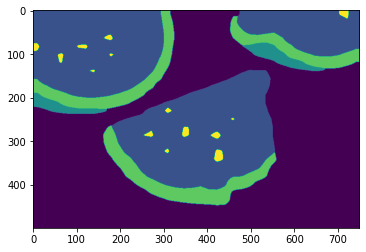

In [16]:
plt.imshow(pred_mask)
plt.show()

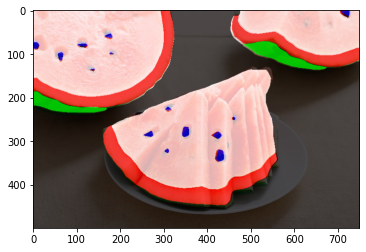

In [22]:
# 可视化预测结果
visualization = show_result_pyplot(model, img, result, opacity=0.7, out_file='pred.jpg')
pred_rgb = mmcv.bgr2rgb(visualization)   #图像bgr转rgb
cv2.imwrite('pred_rgb.jpg', pred_rgb)
plt.imshow(visualization)
plt.show()

## 视频预测-Python API（推荐，快）

### 导入工具包

In [10]:
import numpy as np
import time
import shutil

import torch

from PIL import Image
import cv2

import mmcv
import mmengine
from mmseg.apis import inference_model,show_result_pyplot
from mmseg.utils import register_all_modules
register_all_modules()

from mmseg.datasets import CityscapesDataset

### 载入模型

In [11]:
# 载入 config 配置文件
from mmengine import Config

config_file = Config.fromfile('watermelon_cfg.py')

# 模型 checkpoint 权重文件
checkpoint_file = 'work_dirs/watermelon/iter_800.pth'


In [12]:
from mmseg.apis import init_model
model = init_model(config_file, checkpoint_file, device='cuda:0')

from mmengine.model.utils import revert_sync_batchnorm
if not torch.cuda.is_available():
    model = revert_sync_batchnorm(model)

Loads checkpoint by local backend from path: work_dirs/watermelon/iter_800.pth


### 输入视频路径

In [13]:
# input_video = 'data/traffic.mp4'

input_video = 'data/predict/watermelon_custom.mp4'

### 创建临时文件夹，存放每帧结果

In [14]:
temp_out_dir = time.strftime('%Y%m%d%H%M%S')
os.mkdir(temp_out_dir)
print('创建临时文件夹 {} 用于存放每帧预测结果'.format(temp_out_dir))

创建临时文件夹 20230618125048 用于存放每帧预测结果


## 视频单帧预测——子豪兄版

In [7]:
# 获取 Cityscapes 街景数据集 类别名和调色板
from mmseg.datasets import cityscapes
classes = cityscapes.CityscapesDataset.METAINFO['classes']
palette = cityscapes.CityscapesDataset.METAINFO['palette']

In [8]:
def pridict_single_frame(img, opacity=0.2):
    
    result = inference_model(model, img)
    
    # 将分割图按调色板染色
    seg_map = np.array(result.pred_sem_seg.data[0].detach().cpu().numpy()).astype('uint8')
    seg_img = Image.fromarray(seg_map).convert('P')
    seg_img.putpalette(np.array(palette, dtype=np.uint8))
    
    show_img = (np.array(seg_img.convert('RGB')))*(1-opacity) + img*opacity
    
    return show_img

## 视频单帧预测——本人版

In [15]:
def pridict_single_frame(img, opacity=0.5):
    result = inference_model(model, img)
    pred_mask = result.pred_sem_seg.data[0].cpu().numpy()
    visualization = show_result_pyplot(model, img, result, opacity=opacity)
    
    show_img = mmcv.bgr2rgb(visualization)   #图像bgr转rgb
    
    return show_img

### 视频逐帧预测

In [16]:
# 读入待预测视频
imgs = mmcv.VideoReader(input_video)

prog_bar = mmengine.ProgressBar(len(imgs))

# 对视频逐帧处理
for frame_id, img in enumerate(imgs):
    
    ## 处理单帧画面
    show_img = pridict_single_frame(img, opacity=0.7)
    temp_path = f'{temp_out_dir}/{frame_id:06d}.jpg' # 保存语义分割预测结果图像至临时文件夹
    cv2.imwrite(temp_path, show_img)

    prog_bar.update() # 更新进度条

# 把每一帧串成视频文件
mmcv.frames2video(temp_out_dir, 'seg_video.mp4', fps=imgs.fps, fourcc='mp4v')

shutil.rmtree(temp_out_dir) # 删除存放每帧画面的临时文件夹
print('删除临时文件夹', temp_out_dir)

[                                                  ] 0/897, elapsed: 0s, ETA:06/18 12:51:05 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 897/897, 74.1 task/s, elapsed: 12s, ETA:     0s[                                                  ] 0/897, elapsed: 0s, ETA:
删除临时文件夹 20230618125048


# 测试集性能评估

## 添加数据集类

In [25]:
# 数据集配置文件
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/StanfordBackgroundDataset.py -O mmseg/datasets/StanfordBackgroundDataset.py

# 修改 ../mmsegmentation/mmseg/datasets/__init__.py，添加数据集
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/__init__.py -O mmseg/datasets/__init__.py


--2023-06-15 16:02:22--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/StanfordBackgroundDataset.py
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 455 [binary/octet-stream]
Saving to: ‘../mmsegmentation/mmseg/datasets/StanfordBackgroundDataset.py’

../mmsegmentation/m 100%[===================>]     455  --.-KB/s    in 0s      

2023-06-15 16:02:23 (16.2 MB/s) - ‘../mmsegmentation/mmseg/datasets/StanfordBackgroundDataset.py’ saved [455/455]

--2023-06-15 16:02:23--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/__init__.py
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132


## 测试集精度指标

In [5]:
!python tools/test.py watermelon_cfg.py work_dirs/watermelon/iter_800.pth

06/15 16:17:27 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.10 (default, Jun  4 2021, 15:09:15) [GCC 7.5.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.3, V11.3.109
    GCC: gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
    PyTorch: 1.10.0+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=

## 速度指标-FPS

In [11]:
#测试集过少的话，无法测出速度
!python tools/analysis_tools/benchmark.py watermelon_cfg.py work_dirs/watermelon/iter_800.pth

Run 1:
/root/autodl-tmp/pythonProject/openmmlab_ai/MMSegmentation_homework/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/root/autodl-tmp/pythonProject/openmmlab_ai/MMSegmentation_homework/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
Loads checkpoint by local backend from path: work_dirs/watermelon/iter_800.pth
/root/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid va